## Problem Statement:
Perform neural style transfer using 

## Importing Dependencies and vgg19 model from tensorflow.keras

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.applications.vgg19 as vgg19
import requests ## For getting images from url
from PIL import Image ## For mainipulating Images
from io import BytesIO ## Converting bytes to image
print(tf.__version__)

2.7.0


## Helper Functions

In [2]:
# Load Image from url
'''Parameters
    url: url of image
    target_size: size of image
   Returns
    Image in form of numpy array
'''
def load_image_from_url(url,target_size=None):
    img_request=requests.get(url)
    img=Image.open(BytesIO(img_request.content))
    if target_size==None:
        return np.array(img)
    else:
        return np.array(img.resize(target_size))
# Plot Images in a grid
'''Parameters
    images= list of images to plot
    num_rows= number of images in a row (for multiple image plotting)
'''
def plot_image_grid(images,num_rows=1):
    n=len(images)
    if n > 1:
        num_cols=np.ceil(n/num_rows)
        fig,axes=plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
        axes=axes.flatten()
        fig.set_size_inches((15,15))
        for i,image in enumerate(images):
            axes[i].imshow(image)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(images[0])
# Plot graph from data provided
'''Parameters
    data= list of data to plot
'''
def plot_graph(data):
    plt.plot(data)
    plt.show()

## Defining Style Image URL and Content Image URL

In [3]:
style_url="https://assets.catawiki.nl/assets/2019/7/30/f/8/5/f8508825-ec5a-4f5e-bc61-73ff3ded88e2.jpg"
content_url="https://img.bleacherreport.net/img/images/photos/003/825/453/hi-res-ade0501d521ed2716586baa68416bf81_crop_north.jpg?h=533&w=800&q=70&crop_x=center&crop_y=top"

## Loading Images from url and plotting them

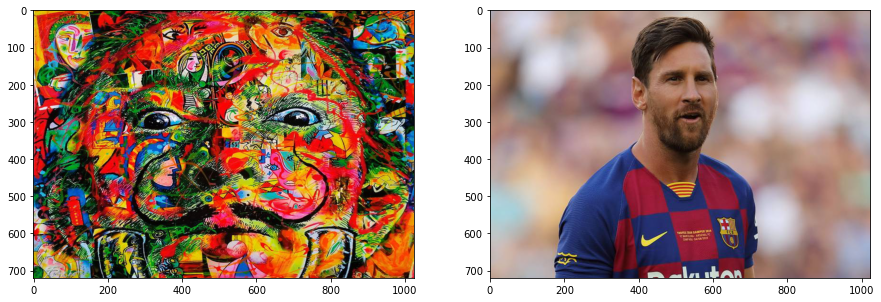

In [4]:
style_image=load_image_from_url(style_url,target_size=(1024,720))
content_image=load_image_from_url(content_url,target_size=(1024,720))
plot_image_grid([style_image,content_image])

## Defining Layers to extract features from

In [5]:
CONTENT_LAYERS=['block4_conv2']
STYLE_LAYERS=['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

## Creating Our Model using Keras Functional API
pooling is set to average pooling as suggested by research paper of neural style transfer.
Model is created by providing it input and output layers

In [6]:
def create_vgg_model():
    model=vgg19.VGG19(include_top=False,pooling='avg',weights='imagenet')
    model.trainable=False
    content_layer=CONTENT_LAYERS
    style_layer=STYLE_LAYERS
    output_layers=[model.get_layer(layer).output for layer in (content_layer + style_layer)]
    return tf.keras.models.Model(model.input,output_layers)

## Preprocess Image to be send as input in vgg model.
VGG model takes images as BGR format instead of RGB format so it needed to be preprocess first 

In [7]:
processed_content_image=vgg19.preprocess_input(np.expand_dims(content_image,axis=0))
processed_style_image=vgg19.preprocess_input(np.expand_dims(style_image,axis=0))

## Helper Function to Deprocess the preprocessed image
Since vgg model takes image as BGR format so after we get output it is also in BGR format so to convert it to RGB format we need this method 

In [8]:
'''Parameters
    processed_img= Processed Image in BGR Format
   Returns
    Image with RGB Format
'''
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Creating Instance of our vgg model

In [9]:
model=create_vgg_model()

## Define Losses


In [10]:
## Returns Content loss between base_content image and new_image which has to be generated by network
'''
 Content Loss= Mean((new_image-base_image)^2)
'''
def get_content_loss(new_image_content,base_image_content):
    return tf.reduce_mean(tf.square(new_image_content-base_image_content))

## Gram Matrix
An important application of Gram Matrix is to compute linear independence. A set of vectors are linearly independent if and only if the Gram determinant (the determinant of the Gram matrix) is non-zero.

In [11]:
## Returns Gram matrix of a Image.
'''
 Gram Matrix of a Image is a matrix which we will use to compute correlation between images and will be used in style loss to compute how style of one image
 is similar to other
'''
def get_gram_matrix(output):
    channels=output.shape[-1]
    a=tf.reshape(output,[-1,channels])
    gram_matrix=tf.matmul(a,a,transpose_a=True)
    n=int(gram_matrix.shape[0])
    return gram_matrix/tf.cast(n,'float32'),n

In [12]:
## Returns Style Loss between base_style image and new_styled which is to be generated
'''
Style Loss= Mean(1/(2 X nH X nW X nC)^2 X (GramMatrix(style_image)-GramMatrix(new_image))^2)
'''
def get_style_loss(new_image_style,base_style):
    new_style_gram,new_gram_height=get_gram_matrix(new_image_style)
    base_style_gram,base_gram_height=get_gram_matrix(base_style)
    assert new_gram_height==base_gram_height 
    gram_features=int(new_style_gram.shape[0])
    gram_channels=int(new_style_gram.shape[-1])
    loss=tf.reduce_mean(tf.square(base_style_gram-new_style_gram)/(2*int(new_gram_height)*(gram_features)*(gram_channels))**2)
    return loss

In [13]:
## Return Total Loss between (content_image,new_image) and (style_image,new_image)
def get_total_loss(new_image_output,base_content_output,base_style_output,alpha=0.001,beta=1):
    new_image_styles=new_image_output[len(CONTENT_LAYERS):]
    base_image_styles=base_style_output[len(CONTENT_LAYERS):]
    style_loss=0
    n=len(new_image_styles)
    for i in range(n):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    new_image_contents=new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents=base_content_output[:len(CONTENT_LAYERS)]
    content_loss=0
    n=len(new_image_contents)
    for i in range(n):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/n
    return alpha*content_loss+ beta*style_loss

## Getting Output from model for content and style images and generating new image
base_style_outputs, base_content_outputs gets output from our model

generated_image is a tensorflow variable which represents new generated image by network and its value will be changed by training it to minimize total loss

In [14]:
base_style_outputs=model(processed_style_image)
base_content_outputs=model(processed_content_image)
generated_image=tf.Variable(processed_content_image+tf.random.normal(processed_content_image.shape))
optimizer=tf.optimizers.Adam(learning_rate=5)

## Optimization Function optimize generated image values based on minimizing total loss function

In [15]:
'''
    Parameters
        iterations= number of times to run optimization
    Returns
        best_image : Best Image in all iterations from network
        images: List of Images that are optimized in every iterations this is to track how number of iterations change image appearence
        losses: Total Loss which can be tracked or plot in each iteration
'''
def optimize(iterations):
    images=[]
    losses=[]
    best_loss=20000000
    best_image=generated_image.numpy()
    for i in range(iterations):
        with tf.GradientTape() as tape:
            print("Iteration ",i)
            tape.watch(generated_image) ## Keep Eye on our generated image and optimize its values
            generated_image_content=model(generated_image) ## get output from model for generated image
            loss=get_total_loss(generated_image_content,base_content_outputs,base_style_outputs) ## find total loss of images
            losses.append(loss.numpy())
            gradient=tape.gradient(loss,generated_image)
            optimizer.apply_gradients(zip([gradient],[generated_image]))
            generated_image_clipped=tf.clip_by_value(generated_image, 0, 255) ## Clip image to be in range 0-255
            generated_image.assign(generated_image_clipped) ## assign clipped value of to generated_image variable
            print("LOSS= {0}".format(loss.numpy()))
            if i%10==0:
                images.append(deprocess_image(generated_image.numpy()))
            if loss<best_loss:
                best_image=generated_image.numpy()
                best_loss=loss
    return best_image,images,losses

## Optimizing and plotting loss

Iteration  0
LOSS= 2751.24853515625
Iteration  1
LOSS= 3418.87353515625
Iteration  2
LOSS= 3309.130615234375
Iteration  3
LOSS= 3183.615478515625
Iteration  4
LOSS= 3046.99072265625
Iteration  5
LOSS= 2900.758544921875
Iteration  6
LOSS= 2747.87255859375
Iteration  7
LOSS= 2591.091552734375
Iteration  8
LOSS= 2434.1650390625
Iteration  9
LOSS= 2281.21484375


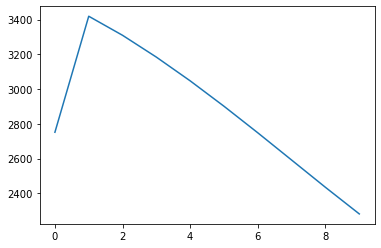

In [16]:
result,images,losses=optimize(10)
plot_graph(losses)

## Plotting all Images which we get in each iteration of optimization

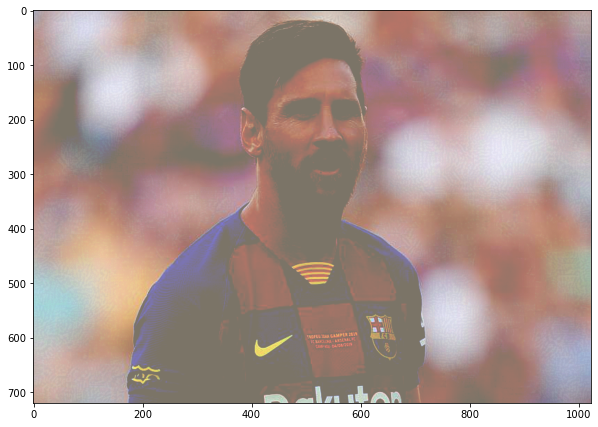

In [17]:
plot_image_grid(images) 

## Plot the Final Best Output from network

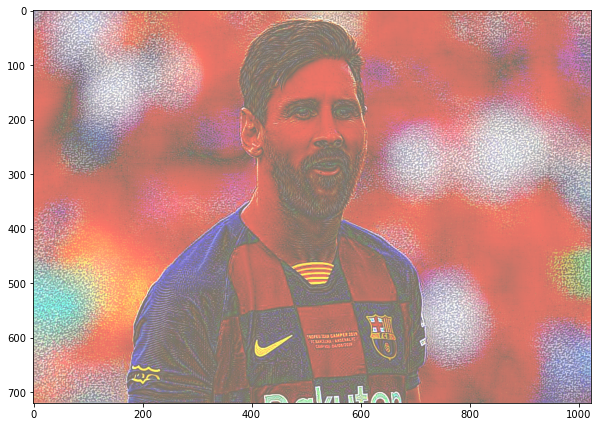

In [18]:
plot_image_grid([deprocess_image(result)]) 

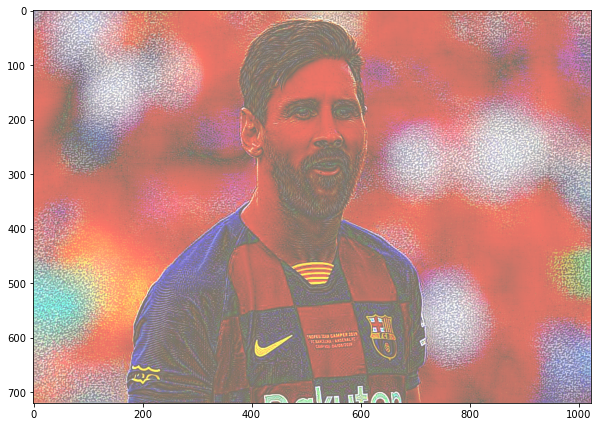

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(deprocess_image(result))